In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('./data/T11-4.DAT', header=None, sep='\s+', names=['x1', 'x2', 'x3', 'x4', 'type'])

In [3]:
df_group = df.groupby('type')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Serif"]
}
sns.set_theme(style="ticks", rc=custom_params)

In [5]:
class CompanyData:
    def __init__(self, data):
        self.df: pd.DataFrame = data
        self.df_group = data.groupby('type')
        self.p1 = 0.5
        self.p2 = 0.5
        self.c12c21_ratio = 1

    def set_p1p2(self, p1, p2):
        self.p1 = p1
        self.p2 = p2

    def pair_plot(self):
        sns.pairplot(self.df, hue='type', markers=['o', 'D'])

    def pair_mean_cov(self, x1, x2):
        x_bar = self.df_group[[x1, x2]].mean().values
        x_cov = self.df_group[[x1, x2]].cov(ddof=1).values.reshape(2, 2, 2)
        return x_bar, x_cov

    def categorical(self, x1, x2):
        x_bar, x_cov = self.pair_mean_cov(x1, x2)
        k = 1/2 * np.log(np.linalg.det(x_cov[0]) / np.linalg.det(x_cov[1])) \
            + 1/2 * (x_bar[0].T @ np.linalg.inv(x_cov[0]) @ x_bar[0] - x_bar[1].T @ np.linalg.inv(x_cov[1]) @ x_bar[1])
        def rule(xx):
            tmp = -1/2 * xx.T @ (np.linalg.inv(x_cov[0]) - np.linalg.inv(x_cov[1])) @ xx \
                  + (x_bar[0].T @ np.linalg.inv(x_cov[0]) - x_bar[1].T @ np.linalg.inv(x_cov[1])) @ xx - k
            if tmp >= np.log(self.c12c21_ratio * self.p2 / self.p1):
                return 0
            else:
                return 1
        return rule

    def draw_categorical(self, x1, x2, ax=None):
        rule = self.categorical(x1, x2)
        x = np.linspace(df[x1].min() - 0.5, df[x1].max() + 0.5, 100)
        y = np.linspace(df[x2].min() - 0.5, df[x2].max() + 0.5, 100)
        xx, yy = np.meshgrid(x, y)
        zz = np.array([rule(np.array([xx[i, j], yy[i, j]])) for i in range(xx.shape[0]) for j in range(xx.shape[1])]).reshape(xx.shape)
        if ax is None:
            plt.contourf(xx, yy, zz, alpha=0.3, colors=['blue', 'black', 'orange', 'orange'])
            sns.scatterplot(x=x1, y=x2, hue='type', markers=['o', 'D'], data=self.df)
        else:
            ax.contourf(xx, yy, zz, alpha=0.3, colors=['blue', 'black', 'orange', 'orange'])
            sns.scatterplot(x=x1, y=x2, hue='type', markers=['o', 'D'], data=self.df, ax=ax)

    def aper(self, x1, x2):
        n1 = self.df_group.size()[0]
        n2 = self.df_group.size()[1]
        n1c = 0
        n2c = 0
        rule = self.categorical(x1, x2)
        for i in df_group.get_group(0)[[x1, x2]].values:
            if rule(i) == 0:
                n1c += 1
        for j in df_group.get_group(1)[[x1, x2]].values:
            if rule(j) == 1:
                n2c += 1
        return (n1 + n2 - n1c - n2c) / (n1 + n2)

    def leave_one_out_categorical(self, x1, x2, i, t):
        df_tmp = self.df.copy()
        if t == 0:
            df_tmp.drop(i, inplace=True)
        else:
            df_tmp.drop(i + self.df_group.size()[0], inplace=True)
        df_tmp_group = df_tmp.groupby('type')
        x_bar = df_tmp_group[[x1, x2]].mean().values
        x_cov = df_tmp_group[[x1, x2]].cov(ddof=1).values.reshape(2, 2, 2)
        k = 1/2 * np.log(np.linalg.det(x_cov[0]) / np.linalg.det(x_cov[1])) \
            + 1/2 * (x_bar[0].T @ np.linalg.inv(x_cov[0]) @ x_bar[0] - x_bar[1].T @ np.linalg.inv(x_cov[1]) @ x_bar[1])
        def rule(xx):
            tmp = -1/2 * xx.T @ (np.linalg.inv(x_cov[0]) - np.linalg.inv(x_cov[1])) @ xx \
                  + (x_bar[0].T @ np.linalg.inv(x_cov[0]) - x_bar[1].T @ np.linalg.inv(x_cov[1])) @ xx - k
            if tmp >= np.log(self.c12c21_ratio * self.p2 / self.p1):
                return 0
            else:
                return 1
        return rule

    def aer(self, x1, x2):
        n1 = self.df_group.size()[0]
        n2 = self.df_group.size()[1]
        n1m = 0
        n2m = 0
        for i in range(n1):
            rule = self.leave_one_out_categorical(x1, x2, i, 0)
            if rule(self.df_group.get_group(0)[[x1, x2]].values[i]) == 1:
                n1m += 1
        for j in range(n2):
            rule = self.leave_one_out_categorical(x1, x2, j, 1)
            if rule(self.df_group.get_group(1)[[x1, x2]].values[j]) == 0:
                n2m += 1
        return (n1m + n2m) / (n1 + n2)


cd = CompanyData(df)
cd.set_p1p2(0.5, 0.5)

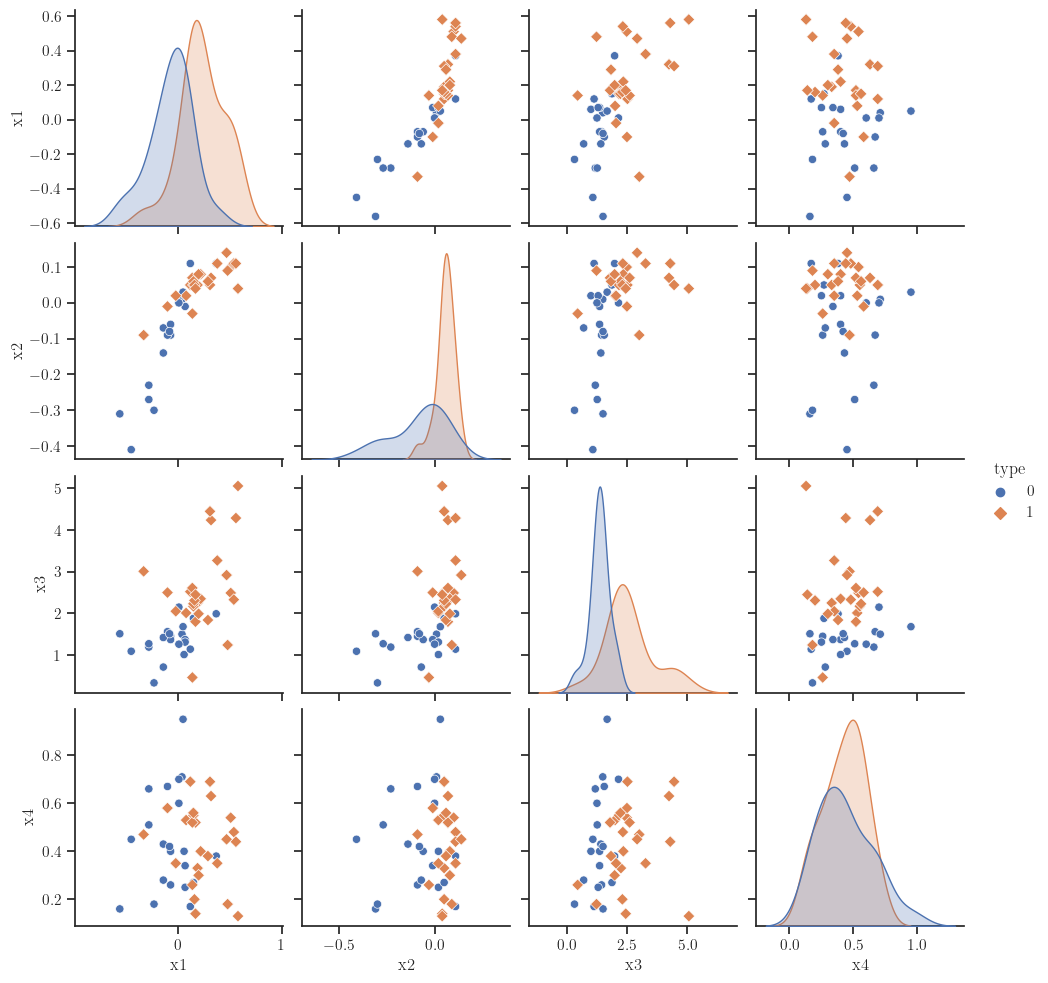

In [6]:
cd.pair_plot()
plt.savefig(f'./hw14/pair_plot.pdf')

In [7]:
print(cd.pair_mean_cov('x1', 'x2'))

(array([[-0.06904762, -0.08142857],
       [ 0.2352    ,  0.0556    ]]), array([[[0.04412905, 0.02847643],
        [0.02847643, 0.02100286]],

       [[0.047051  , 0.00850717],
        [0.00850717, 0.00237567]]]))


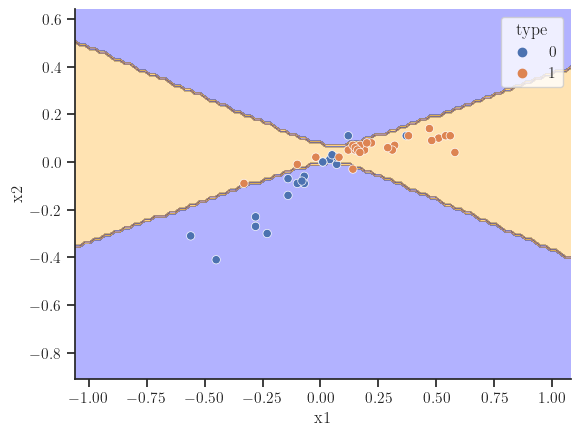

In [8]:
cd.draw_categorical('x1', 'x2')
plt.savefig(f'./hw14/cat_x1_x2.pdf')

In [9]:
print(cd.aper('x1', 'x2'))
print(cd.aer('x1', 'x2'))

0.1956521739130435
0.21739130434782608


In [10]:
cd.set_p1p2(0.05, 0.95)

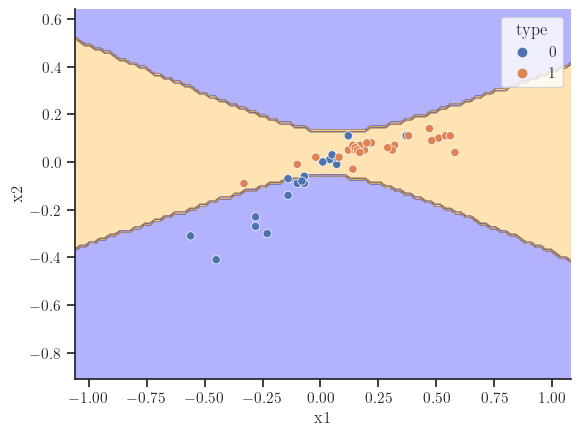

In [11]:
cd.draw_categorical('x1', 'x2')
plt.savefig(f'./hw14/cat_x1_x2e.pdf')

In [12]:
print(cd.aper('x1', 'x2'))
print(cd.aer('x1', 'x2'))

0.2608695652173913
0.2608695652173913


### g

In [13]:
cd.set_p1p2(0.5, 0.5)

In [14]:
print(cd.pair_mean_cov('x1', 'x3'))
print(cd.pair_mean_cov('x1', 'x4'))

(array([[-0.06904762,  1.36666667],
       [ 0.2352    ,  2.5936    ]]), array([[[0.04412905, 0.03449333],
        [0.03449333, 0.16430333]],

       [[0.047051  , 0.0749305 ],
        [0.0749305 , 1.046774  ]]]))
(array([[-0.06904762,  0.43761905],
       [ 0.2352    ,  0.4268    ]]), array([[[ 0.04412905,  0.00414738],
        [ 0.00414738,  0.04457905]],

       [[ 0.047051  , -0.0067035 ],
        [-0.0067035 ,  0.026381  ]]]))


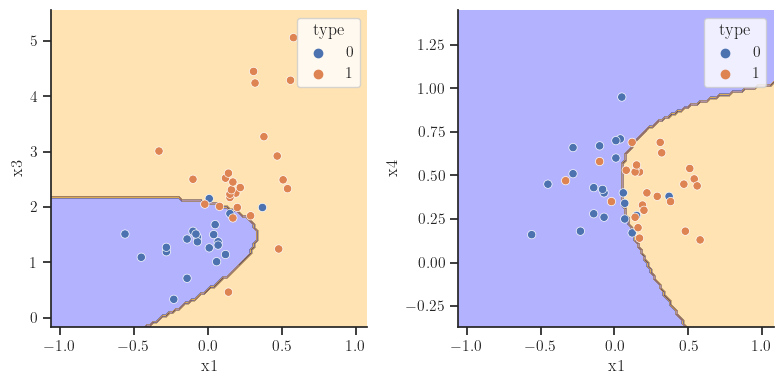

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cd.draw_categorical('x1', 'x3', axes[0])
cd.draw_categorical('x1', 'x4', axes[1])
fig.tight_layout()
plt.savefig(f'./hw14/cat_x1_x3_x4.pdf')

In [16]:
print(cd.aper('x1', 'x3'))
print(cd.aer('x1', 'x3'))
print(cd.aper('x1', 'x4'))
print(cd.aer('x1', 'x4'))

0.10869565217391304
0.13043478260869565
0.17391304347826086
0.21739130434782608


In [17]:
cd.set_p1p2(0.05, 0.95)

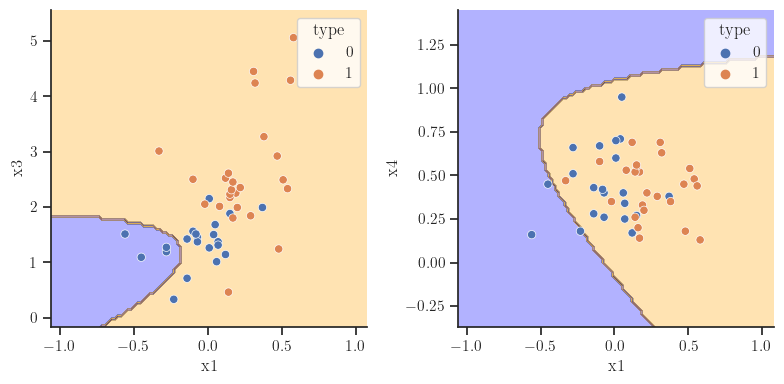

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cd.draw_categorical('x1', 'x3', axes[0])
cd.draw_categorical('x1', 'x4', axes[1])
fig.tight_layout()
plt.savefig(f'./hw14/cat_x1_x3_x4e.pdf')

In [19]:
print(cd.aper('x1', 'x3'))
print(cd.aer('x1', 'x3'))
print(cd.aper('x1', 'x4'))
print(cd.aer('x1', 'x4'))

0.3695652173913043
0.391304347826087
0.391304347826087
0.45652173913043476


In [20]:
cd.set_p1p2(0.5, 0.5)

In [21]:
print(cd.pair_mean_cov('x2', 'x3'))

(array([[-0.08142857,  1.36666667],
       [ 0.0556    ,  2.5936    ]]), array([[[0.02100286, 0.02602   ],
        [0.02602   , 0.16430333]],

       [[0.00237567, 0.00858317],
        [0.00858317, 1.046774  ]]]))


In [22]:
print(cd.pair_mean_cov('x2', 'x4'))

(array([[-0.08142857,  0.43761905],
       [ 0.0556    ,  0.4268    ]]), array([[[0.02100286, 0.00344143],
        [0.00344143, 0.04457905]],

       [[0.00237567, 0.00018533],
        [0.00018533, 0.026381  ]]]))


In [23]:
print(cd.pair_mean_cov('x3', 'x4'))

(array([[1.36666667, 0.43761905],
       [2.5936    , 0.4268    ]]), array([[[0.16430333, 0.03278167],
        [0.03278167, 0.04457905]],

       [[1.046774  , 0.03263283],
        [0.03263283, 0.026381  ]]]))


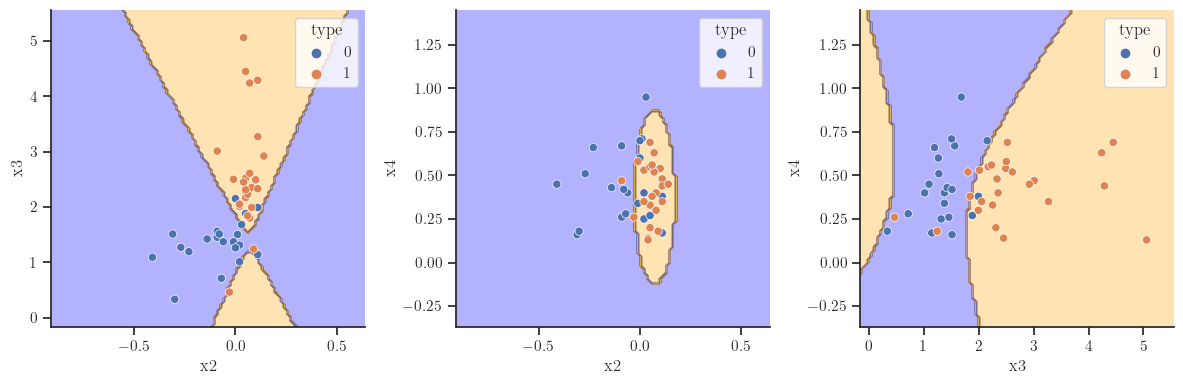

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cd.draw_categorical('x2', 'x3', axes[0])
cd.draw_categorical('x2', 'x4', axes[1])
cd.draw_categorical('x3', 'x4', axes[2])
fig.tight_layout()
plt.savefig(f'./hw14/cat_x2_x3_x4.pdf')

In [25]:
print(cd.aper('x2', 'x3'))
print(cd.aer('x2', 'x3'))
print(cd.aper('x2', 'x4'))
print(cd.aer('x2', 'x4'))
print(cd.aper('x3', 'x4'))
print(cd.aer('x3', 'x4'))

0.10869565217391304
0.17391304347826086
0.2391304347826087
0.2608695652173913
0.13043478260869565
0.17391304347826086


In [26]:
cd.set_p1p2(0.05, 0.95)

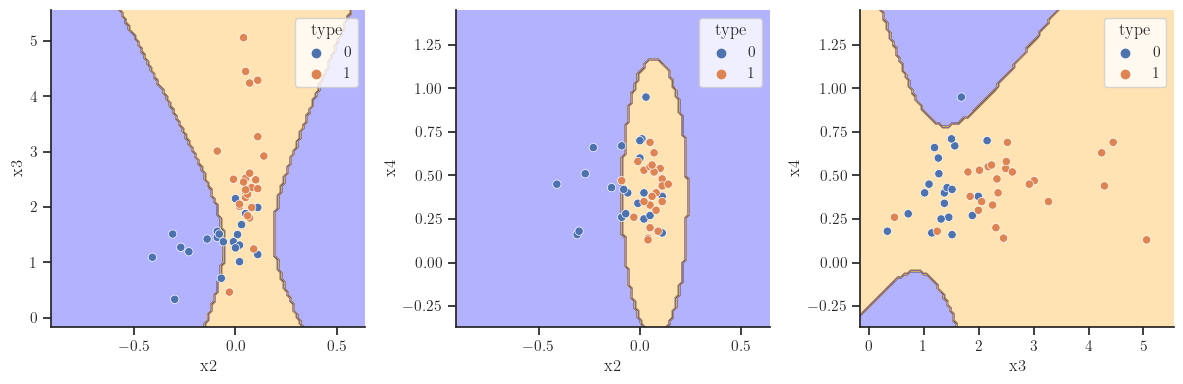

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cd.draw_categorical('x2', 'x3', axes[0])
cd.draw_categorical('x2', 'x4', axes[1])
cd.draw_categorical('x3', 'x4', axes[2])
fig.tight_layout()
plt.savefig(f'./hw14/cat_x2_x3_x4e.pdf')

In [28]:
print(cd.aper('x2', 'x3'))
print(cd.aer('x2', 'x3'))
print(cd.aper('x2', 'x4'))
print(cd.aer('x2', 'x4'))
print(cd.aper('x3', 'x4'))
print(cd.aer('x3', 'x4'))

0.2391304347826087
0.2391304347826087
0.30434782608695654
0.30434782608695654
0.43478260869565216
0.45652173913043476
